In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from matplotlib.patches import Rectangle
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import to_rgb
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple

In [2]:
# Load datasets
path = "../Data/"
tm_2022 = pd.read_csv("{}team_stats_2021_2022.csv".format(path), sep=';', encoding='latin-1') 
tm_2023 = pd.read_csv("{}team_stats_2022_2023.csv".format(path), sep=';', encoding='latin-1')

In [3]:
# Define functions for data processing and plotting
def label_rk(rank):
    labels = ["Top 5", "Top 10", "Top 15", "Top 20"]
    RkLg = np.arange(6, 22, 5)
    idx = np.where(rank < RkLg)[0][0]
    return labels[idx]

In [4]:
# Process datasets
tm_2022["Top_Team_Scorer_name"] = tm_2022["Top Team Scorer"].apply(lambda x: " ".join(x.split(" ")[:-2]))
tm_2023["Top_Team_Scorer_name"] = tm_2023["Top Team Scorer"].apply(lambda x: " ".join(x.split(" ")[:-2]))
tm_2022["Top_Team_Scorer_goals"] = tm_2022["Top Team Scorer"].apply(lambda x: x.split(" ")[-1]).astype("int64")
tm_2023["Top_Team_Scorer_goals"] = tm_2023["Top Team Scorer"].apply(lambda x: x.split(" ")[-1]).astype("int64")
tm_2022["Top_Team_Scorer_contribution"] = tm_2022["Top_Team_Scorer_goals"]/tm_2022["GF"]
tm_2023["Top_Team_Scorer_contribution"] = tm_2023["Top_Team_Scorer_goals"]/tm_2023["GF"]
tm_2022["LgRk_label"] = tm_2022["LgRk"].apply(label_rk)
tm_2023["LgRk_label"] = tm_2023["LgRk"].apply(label_rk)
tm_2022["GD_xGD_diff"] = tm_2022["GD"]- tm_2022["xGD"]
tm_2023["GD_xGD_diff"] = tm_2023["GD"]- tm_2023["xGD"]
tm_2022.rename(columns = {"Pts/G":"Pts/MP"}, inplace=True)

del tm_2022["Top Team Scorer"], tm_2023["Top Team Scorer"]

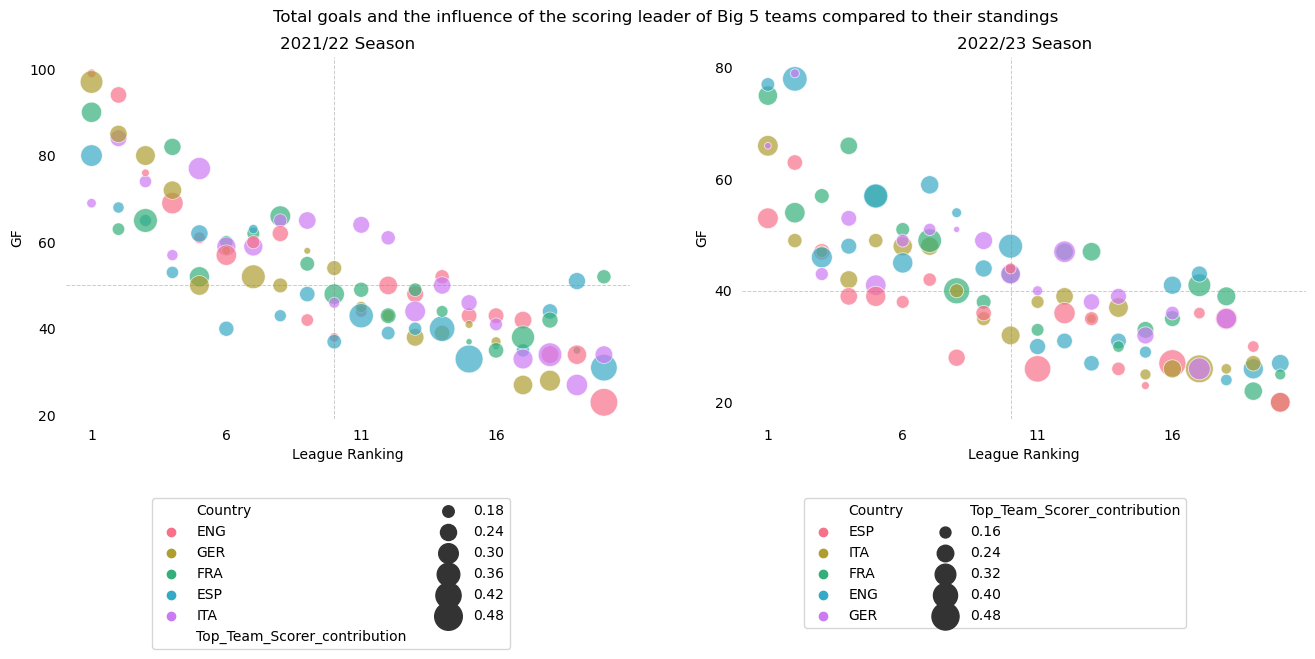

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4.7))
y_ticks = [range(20, 110, 20), range(20, 90, 20)]
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="LgRk", y="GF", size="Top_Team_Scorer_contribution", hue="Country", alpha=0.7,
                    legend=True, palette="husl", sizes=(20, 400), ax=ax[i])
    ax[i].set_xticks(range(1, 21, 5), labels=range(1, 21, 5))
    ax[i].set_yticks(y_ticks[i], labels=y_ticks[i])
    ax[i].axvline(10, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season".format(title[i]))
    ax[i].set_xlabel("League Ranking")
    ax[i].legend(bbox_to_anchor=(0.8, -0.2), ncol=2)

sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Total goals and the influence of the scoring leader of Big 5 teams compared to their standings")
plt.show()

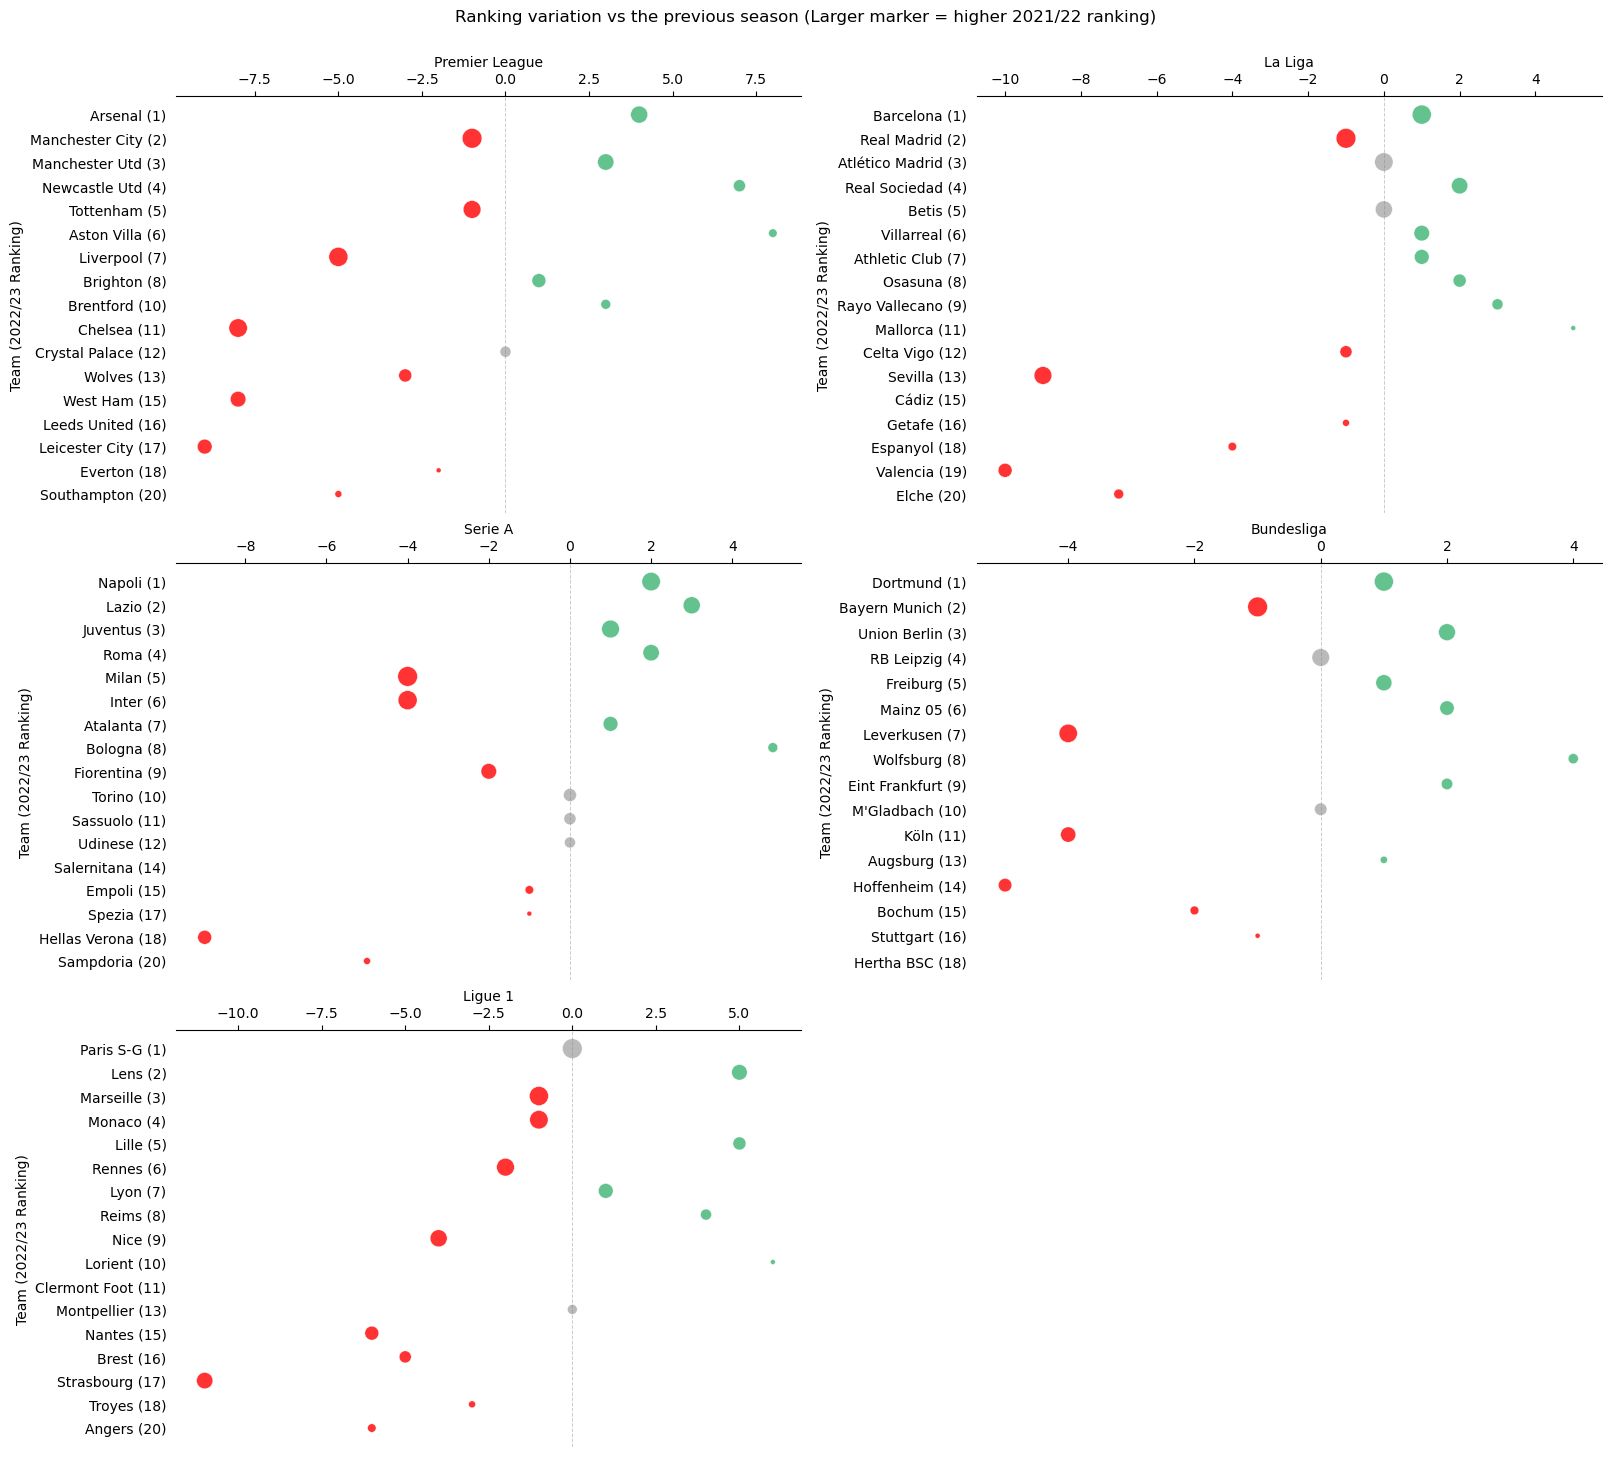

In [6]:
fig, ax = plt.subplots(3, 2, figsize = (16, 14), layout='constrained')
ax[2,1].axis("off")
d_country = {0:['ENG', 'ESP'], 1:['ITA', 'GER'], 2:['FRA']}
d_league = {'ENG': 'Premier League', 'ESP': 'La Liga', 'ITA': 'Serie A', 'GER': 'Bundesliga', 'FRA': 'Ligue 1'}
colors = {-1:"red", 0:"darkgrey", 1:"mediumseagreen"}

for i in range(5):
    country = d_country[i//2][i%2]
    teams_22 = set(tm_2022[tm_2022.Country == country].Squad)
    teams_23 = set(tm_2023[tm_2023.Country == country].Squad)
    rk_2023 = tm_2023[tm_2023.Squad.apply(lambda x: x in (teams_22 & teams_23))].sort_values(by="LgRk").Squad.values
    rk_diff = {squad : tm_2022[tm_2022.Squad==squad].LgRk.iloc[0] - tm_2023[tm_2023.Squad==squad].LgRk.iloc[0] for squad in (teams_22 & teams_23)}
    df_tmp = pd.DataFrame(rk_diff, index = np.arange(1)).T.rename(columns = {0: "Rk_diff"})
    df_tmp["color_enc"] = df_tmp["Rk_diff"].apply(lambda x: 1*(x>0) -1*(x<0))
    df_tmp["Squad"] = df_tmp.index
    df_tmp["Rk_2022_size"] = df_tmp.Squad.apply(lambda x: 500 - 20*tm_2022[tm_2022.Squad==x].LgRk.iloc[0])
    df_tmp["Rk_2023_label"] = df_tmp.Squad.apply(lambda x: x + " ({})".format(str(tm_2023[tm_2023.Squad==x].LgRk.iloc[0])))
    
    sns.scatterplot(df_tmp.loc[rk_2023,:], x ="Rk_diff", y="Rk_2023_label", hue="color_enc", legend=False, \
                    palette=colors, alpha=0.8, size='Rk_2022_size', sizes=(0, 200), marker="o", ax=ax[i//2, i%2])
    ax[i//2, i%2].axvline(0, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i//2, i%2].set_xlabel("{}".format(d_league[country]))
    ax[i//2, i%2].xaxis.set_label_position('top')
    ax[i//2, i%2].set_ylabel("Team (2022/23 Ranking)") 
    ax[i//2, i%2].tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, left=False)
    ax[i//2, i%2].spines[['right', 'left', 'bottom']].set_visible(False)

plt.suptitle("Ranking variation vs the previous season (Larger marker = higher 2021/22 ranking)", y=1.03)
plt.show()
del teams_22, teams_23, rk_diff, df_tmp

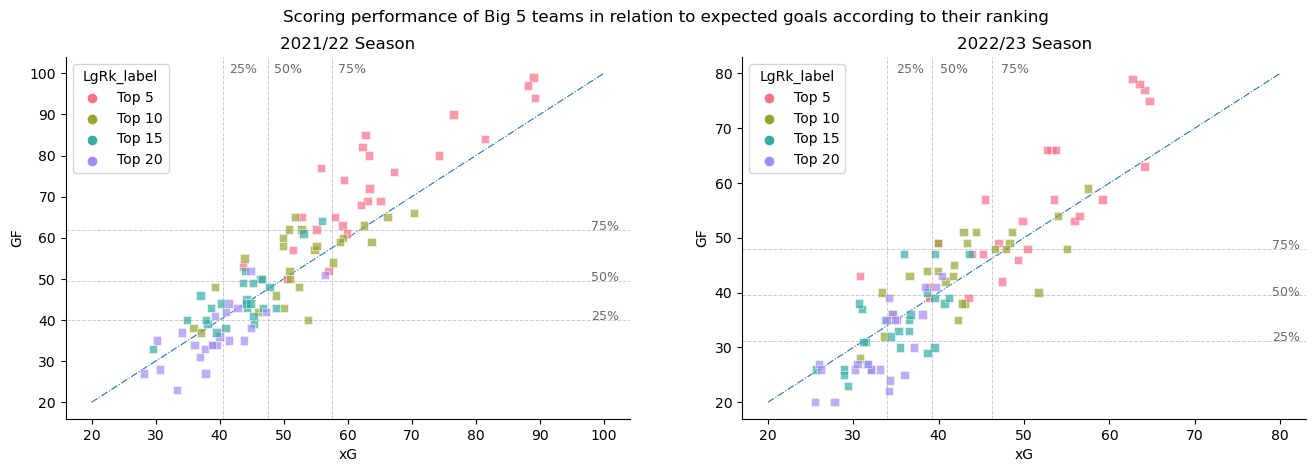

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
line = [np.linspace(20, 100, 2), np.linspace(20, 80, 2)]
x_text, y_text = [98, 79], [100, 80]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="xG", y="GF", hue="LgRk_label", alpha=0.7, marker="s", legend=True, palette="husl", ax=ax[i], zorder=2)
    ax[i].plot(line[i], line[i], linestyle="-.", linewidth=0.8, zorder=1)
    ax[i].set_title("{} Season".format(title[i]))
    for q in np.arange(0.25, 1, 0.25):
        ax[i].axvline(np.quantile(data[i].xG, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(np.quantile(data[i].xG, q)+1, y_text[i], f"{int(100*q)}%", size=9, color="dimgrey")
        ax[i].axhline(np.quantile(data[i].GF, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(x_text[i], np.quantile(data[i].GF, q), f"{int(100*q)}%", size=9, color="dimgrey")
    
sns.despine()
plt.suptitle("Scoring performance of Big 5 teams in relation to expected goals according to their ranking")
plt.show()

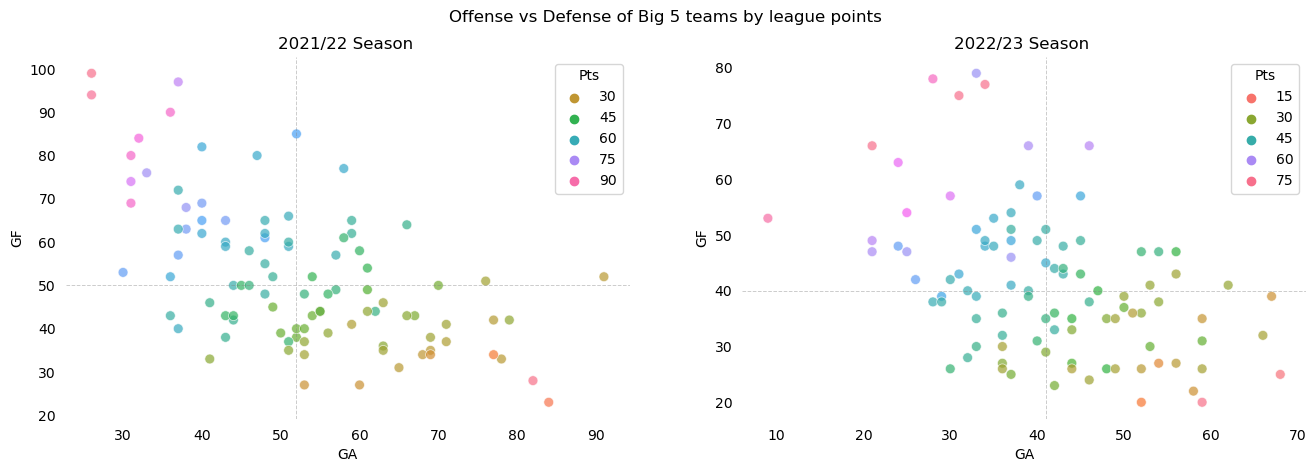

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="GA", y="GF", hue="Pts", alpha=0.7, legend=True, palette="husl", s=50, ax=ax[i])
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axvline(np.round(np.median(data[i].GA)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season ".format(title[i]))

sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Offense vs Defense of Big 5 teams by league points") 
plt.show()

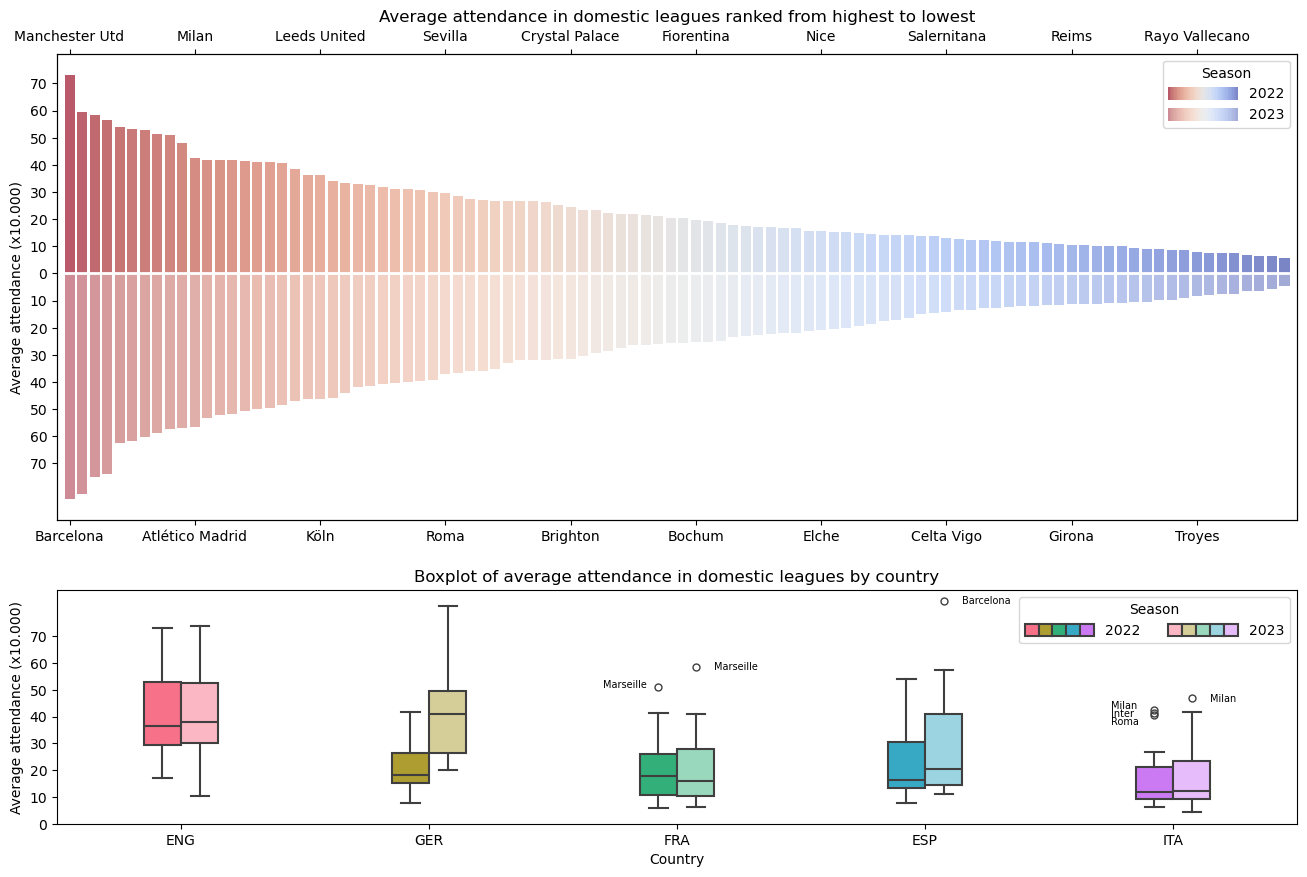

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})
# Upper figure
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

sns.barplot(tm_2022.sort_values(by="Attendance", ascending=False), x="Squad", y="Attendance",
            palette="coolwarm_r", alpha=0.75, lw=0, ax=ax[0])

sns.barplot(tm_2023.sort_values(by="Attendance"), x="Squad", y="Attendance", 
            palette="coolwarm_r", alpha=0.52, lw=0, ax=ax[0])

ax[0].set_xticks(range(0, len(tm_2022)+1, 10), labels=tm_2022.sort_values(by="Attendance", ascending=False).Squad.values[::10], rotation = 0)
ax[0].set_yticks(range(-70000, 75000, 10000), labels=list(range(10, 75, 10))[::-1] + list(range(0, 75, 10)))
ax_ = ax[0].twiny()
ax[0].tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
ax_.tick_params(labelbottom=True, bottom=True, labeltop=False, top=False)
ax_.set_xticks(range(0, len(tm_2023)+1, 10), labels=tm_2023.sort_values(by="Attendance").Squad.values[::10], rotation = 0)
ax[0].set_xlabel("")
ax[0].set_ylabel("Average attendance (x10.000)")
ax[0].set_title("Average attendance in domestic leagues ranked from highest to lowest")
ax[0].set_xlim(-1, len(tm_2022))
ax[0].axhline(0, color="white", linewidth=2)
ax_.set_xlim(-1, len(tm_2023))
handles = [tuple([p for p in ax[0].patches][98*i:98*(i+1):2]) for i in range(2)]
ax[0].legend(handles=handles, labels = ["2022", "2023"], title="Season", 
              handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

tm_2022.insert(0, "Season", 2022)
tm_2023.insert(0, "Season", 2023)

# Lower figure  
df_tmp = pd.concat([tm_2022, tm_2023])
hue_order = ['2022', '2023']
colors = sns.color_palette("husl", 5)

sns.boxplot(df_tmp, x="Country", y="Attendance", hue="Season", width=0.3, saturation=0.5, ax=ax[1], 
            flierprops={"marker": "o", "markerfacecolor":"None"})

# Custom box colors
box_colors = [f + (1 - f) * np.array(to_rgb(c))
              for c in colors for f in np.linspace(0, 0.5, len(hue_order))]

box_patches = [p for p in ax[1].patches if isinstance(p, PathPatch)]

for patch, c in zip(box_patches, box_colors):
    patch.set_facecolor(c)

for collection, color in zip(ax[1].collections, box_colors):
    collection.set_facecolor(color)

annotate = {"x": [1.7, 2.15, 3.15, 3.75, 3.75, 3.75, 4.15], 
            "y": [int(x*1000) for x in [50.7, 57.55, 82, 43, 40, 37, 45.7]],
            "s": ["Marseille", "Marseille", "Barcelona", "Milan", "Inter", "Roma", "Milan"]}

for x, y, s in zip(annotate["x"], annotate["y"], annotate["s"]):
    ax[1].text(x=x, y=y, s=s, fontsize=7)

ax[1].set_yticks(range(0, 75000, 10000), labels=range(0, 75, 10))
ax[1].set_ylabel("Average attendance (x10.000)")
ax[1].set_title("Boxplot of average attendance in domestic leagues by country")

handles = [tuple(box_patches[i::len(hue_order)]) for i in range(len(hue_order))]
ax[1].legend(handles=handles, labels=hue_order, title="Season", ncol=2,
          handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

plt.show()

del tm_2022["Season"], tm_2023["Season"]